In [13]:
import math
import pandas as pd
from torch import nn
import torch

In [14]:
def read_data(file):
    df = pd.read_csv(file, parse_dates=["datetime"])
    df = df.set_index("datetime")

    # Sort by datetime to ensure proper time series order
    df = df.sort_index()

    # Convert boolean fields to proper boolean types
    df['holiday'] = df['holiday'].astype(bool)
    df['workingday'] = df['workingday'].astype(bool)

    # Handle any missing values
    df = df.fillna(method='ffill').fillna(method='bfill')

    # Create additional time-based features
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month

    return df

train_df = read_data("data/train.csv")
train_df

C:\Users\anna.gavrilova.TENZORTECH\AppData\Local\Temp\ipykernel_27336\4258966883.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day_of_week,month
datetime,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,False,False,1,9.84,14.395,81,0.0000,3,13,16,0,5,1
2011-01-01 01:00:00,1,False,False,1,9.02,13.635,80,0.0000,8,32,40,1,5,1
2011-01-01 02:00:00,1,False,False,1,9.02,13.635,80,0.0000,5,27,32,2,5,1
2011-01-01 03:00:00,1,False,False,1,9.84,14.395,75,0.0000,3,10,13,3,5,1
2011-01-01 04:00:00,1,False,False,1,9.84,14.395,75,0.0000,0,1,1,4,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,False,True,1,15.58,19.695,50,26.0027,7,329,336,19,2,12
2012-12-19 20:00:00,4,False,True,1,14.76,17.425,57,15.0013,10,231,241,20,2,12
2012-12-19 21:00:00,4,False,True,1,13.94,15.910,61,15.0013,4,164,168,21,2,12


In [15]:
# Load the dataset
train_df = read_data("data/train.csv")
test_df = read_data("data/test.csv")

train_df.head(3)

C:\Users\anna.gavrilova.TENZORTECH\AppData\Local\Temp\ipykernel_27336\4258966883.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')
C:\Users\anna.gavrilova.TENZORTECH\AppData\Local\Temp\ipykernel_27336\4258966883.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day_of_week,month
datetime,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,False,False,1,9.84,14.395,81,0.0,3,13,16,0,5,1
2011-01-01 01:00:00,1,False,False,1,9.02,13.635,80,0.0,8,32,40,1,5,1
2011-01-01 02:00:00,1,False,False,1,9.02,13.635,80,0.0,5,27,32,2,5,1


In [16]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        # x: (B, T, D)
        return x + self.pe[:, : x.size(1)]

In [17]:
class TransformerTimeSeriesModel(nn.Module):
    def __init__(
        self,
        input_size: int,
        d_model: int,
        nhead: int,
        num_layers: int,
        dim_feedforward: int,
        dropout: float,
        context_length: int,
        prediction_length: int,
        output_variance: bool = True,
    ):
        super().__init__()
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.d_model = d_model
        self.output_variance = output_variance

        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len=context_length)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        out_dim = prediction_length * (2 if output_variance else 1)
        self.head = nn.Linear(d_model, out_dim)

    def forward(self, x):
        # x: (B, context_length, 1)
        h = self.input_proj(x)
        h = self.pos_enc(h)
        h = self.encoder(h)  # (B, T, D)
        # Use representation of last time step
        h_last = h[:, -1, :]  # (B, D)
        out = self.head(h_last)  # (B, pred_len*(...))
        if self.output_variance:
            mean, log_var = out.chunk(2, dim=-1)
            mean = mean.view(-1, self.prediction_length)
            log_var = log_var.view(-1, self.prediction_length)
            return mean, log_var.clamp(-7, 7)
        else:
            mean = out.view(-1, self.prediction_length)
            return mean, None

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

context_length = 24
prediction_length = 1

model = TransformerTimeSeriesModel(
    input_size=1,
    d_model=64,
    nhead=4,
    num_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    context_length=context_length,
    prediction_length=prediction_length,
    output_variance=True,
).to(device)

C:\Users\anna.gavrilova.TENZORTECH\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


## Train the model

In [19]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Prepare training data
def create_sequences(data, context_length, prediction_length):
    """Create input-output sequences for training"""
    X, y = [], []
    for i in range(len(data) - context_length - prediction_length + 1):
        X.append(data[i:i + context_length])
        y.append(data[i + context_length:i + context_length + prediction_length])
    return np.array(X), np.array(y)

# Extract target column (assuming 'count' or similar target variable)
target_col = 'count'  # Adjust based on your dataset
train_data = train_df[target_col].values

# Create sequences
X_train, y_train = create_sequences(train_data, context_length, prediction_length)

# Convert to tensors
X_train = torch.FloatTensor(X_train).unsqueeze(-1)  # Add feature dimension
y_train = torch.FloatTensor(y_train)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training setup
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

# Training loop
model.train()
for epoch in range(num_epochs):
    print("Epoch", epoch)
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()

        # Forward pass
        mean_pred, log_var_pred = model(batch_x)

        # Calculate loss (negative log-likelihood for Gaussian)
        if log_var_pred is not None:
            var_pred = torch.exp(log_var_pred)
            loss = 0.5 * (torch.log(2 * np.pi * var_pred) +
                         (batch_y - mean_pred)**2 / var_pred).mean()
        else:
            loss = nn.MSELoss()(mean_pred, batch_y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

print("Training completed!")

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch [10/10], Loss: 6.4098
Training completed!


In [20]:
class TransformerACPIWrapper:
    def __init__(self, transformer_model, device, context_length):
        self.model = transformer_model
        self.device = device
        self.context_length = context_length
        self.model.eval()

    def predict(self, X):
        """
        Predict using the transformer model for ACPI
        X: numpy array of shape (n_samples, context_length)
        Returns: numpy array of predictions
        """
        # Convert to tensor and add feature dimension
        X_tensor = torch.FloatTensor(X).unsqueeze(-1).to(self.device)

        with torch.no_grad():
            mean_pred, log_var_pred = self.model(X_tensor)
            # Return mean predictions for ACPI
            return mean_pred.cpu().numpy().flatten()

In [21]:
# Prepare test data for ACPI
def prepare_acpi_data(data, context_length, test_split=0.3, cal_split=0.5):
    """Prepare data splits for ACPI training"""
    # Create sequences
    X, y = create_sequences(data, context_length, prediction_length=1)

    # Split into train/test
    n_test = int(len(X) * test_split)
    X_temp, X_test = X[:-n_test], X[-n_test:]
    y_temp, y_test = y[:-n_test], y[-n_test:]

    # Split remaining into train/calibration
    n_cal = int(len(X_temp) * cal_split)
    X_train, X_cal = X_temp[:-n_cal], X_temp[-n_cal:]
    y_train, y_cal = y_temp[:-n_cal], y_temp[-n_cal:]

    return X_train, X_cal, X_test, y_train.flatten(), y_cal.flatten(), y_test.flatten()

# Prepare data
X_train_acpi, X_cal, X_test, y_train_acpi, y_cal, y_test = prepare_acpi_data(
    train_data, context_length
)

In [22]:
# Create transformer wrapper for ACPI
transformer_wrapper = TransformerACPIWrapper(model, device, context_length)

# Initialize ACPI with the transformer model
from acpi import ACPI
from acpi.utils import compute_coverage

alpha = 0.1  # 90% prediction intervals

acpi = ACPI(
    model_cali=transformer_wrapper,
    n_estimators=100,
    max_depth=20,
    min_node_size=10
)

# Fit ACPI on calibration data
acpi.fit(X_cal, y_cal, nonconformity_func=None)

# Fit calibration
acpi.fit_calibration(X_cal, y_cal, nonconformity_func=None, quantile=1-alpha, only_qrf=True)

# Generate prediction intervals
y_lower, y_upper = acpi.predict_pi(X_test, method='qrf')

# Compute coverage
coverage = compute_coverage(y_test, y_lower, y_upper)
print(f'ACPI Coverage: {coverage:.4f}')
print(f'Target Coverage: {1-alpha:.4f}')

100%|██████████| 50/50 [02:56<00:00,  3.53s/it]


ACPI Coverage: 0.8861
Target Coverage: 0.9000


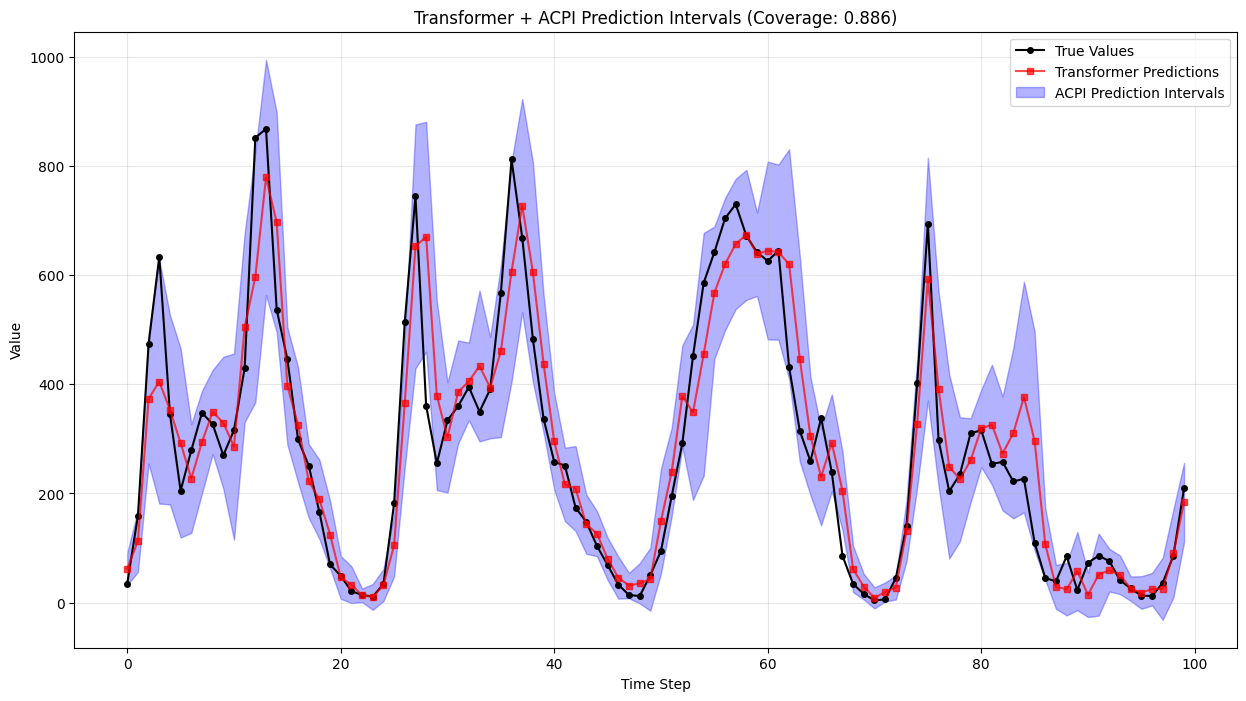

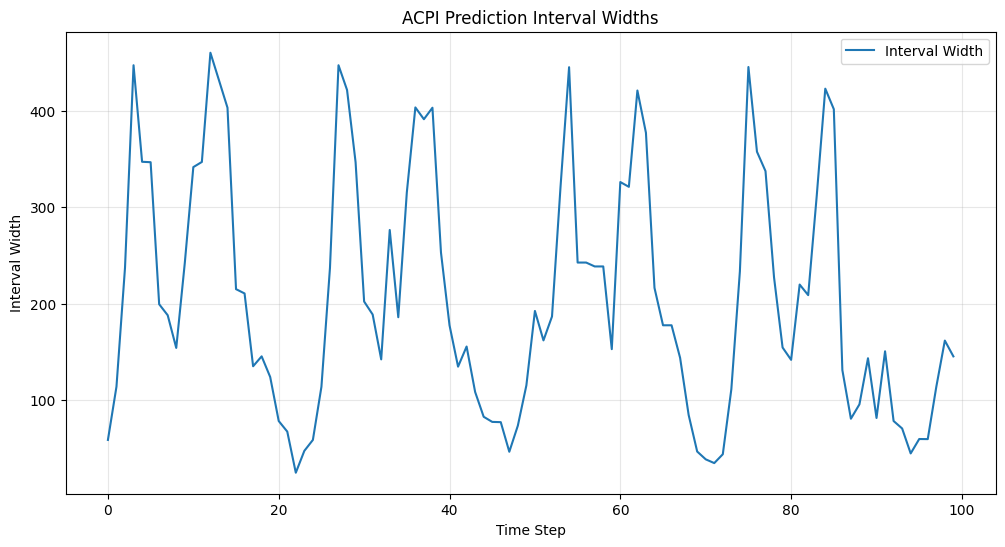

In [23]:
# Visualize results
import matplotlib.pyplot as plt

# Get transformer predictions for comparison
transformer_preds = transformer_wrapper.predict(X_test)

# Plot first 100 predictions
n_plot = min(100, len(y_test))
indices = range(n_plot)

plt.figure(figsize=(15, 8))

# Plot true values
plt.plot(indices, y_test[:n_plot], 'o-', label='True Values', color='black', markersize=4)

# Plot transformer predictions
plt.plot(indices, transformer_preds[:n_plot], 's-', label='Transformer Predictions',
         color='red', markersize=4, alpha=0.7)

# Plot ACPI prediction intervals
plt.fill_between(indices, y_lower[:n_plot], y_upper[:n_plot],
                 alpha=0.3, label='ACPI Prediction Intervals', color='blue')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title(f'Transformer + ACPI Prediction Intervals (Coverage: {coverage:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot interval widths
interval_widths = y_upper - y_lower
plt.figure(figsize=(12, 6))
plt.plot(interval_widths[:n_plot], label='Interval Width')
plt.xlabel('Time Step')
plt.ylabel('Interval Width')
plt.title('ACPI Prediction Interval Widths')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [24]:
# measure how many times the ture value was above or below the prediction interval
n_below = (y_test < y_lower).sum()
n_above = (y_test > y_upper).sum()
n_within = ((y_test >= y_lower) & (y_test <= y_upper)).sum()
total = len(y_test)

print(f'Below: {n_below} ({n_below/total:.2%}), Above: {n_above} ({n_above/total:.2%}), Within: {n_within} ({n_within/total:.2%})')

Below: 190 (5.83%), Above: 181 (5.56%), Within: 2887 (88.61%)
